# Figure Generation Code: planet_tile2img

In [72]:
import rasterio as rio
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
import pandas as pd
import numpy as np

import xarray as xr
from rasterio.plot import show

In [140]:
# Import Velocity Rastors
S2_raster_path = '/Volumes/SGlacier/SK_vmaps_2020_2021/velocity_20200904_20200914_100m_S2.tif'
PS_raster_path = '/Volumes/SGlacier/autorift_OUTPUT_PSsurge/velocity_20200906_20200912_100m_PS.tif'

#specify plot params
fs = 18
tickspacing = 50
y1 = 90; y2 = 360
x1 = 90; x2 = 360

#sentinel2
reader = rio.open(S2_raster_path);
S2r = reader.read(3);
imgres = reader.transform[0]
xdS2, ydS2 = S2r.shape
xS2_utms = np.arange(reader.bounds[0]+x1*imgres,reader.bounds[0]+x2*imgres,tickspacing*imgres).astype(int)/1000
yS2_utms = np.flip(np.arange(reader.bounds[1]+y1*imgres,reader.bounds[1]+y2*imgres,tickspacing*imgres).astype(int)/1000)

#planetscope
reader = rio.open(PS_raster_path); PSr = reader.read(3)
PSr = reader.read(3);
imgres = reader.transform[0]
xdPS, ydPS = PSr.shape
xPS_utms = np.arange(reader.bounds[0]+x1*imgres,reader.bounds[0]+x2*imgres,tickspacing*imgres).astype(int)/1000
yPS_utms = np.flip(np.arange(reader.bounds[1]+y1*imgres,reader.bounds[1]+y2*imgres,tickspacing*imgres).astype(int)/1000)

S2r_data = S2r.copy() # make a copy of the data
PSr_data = PSr.copy() # make a copy of the data
    
# Subtract The Rasters
difference_raster = S2r_data - PSr_data

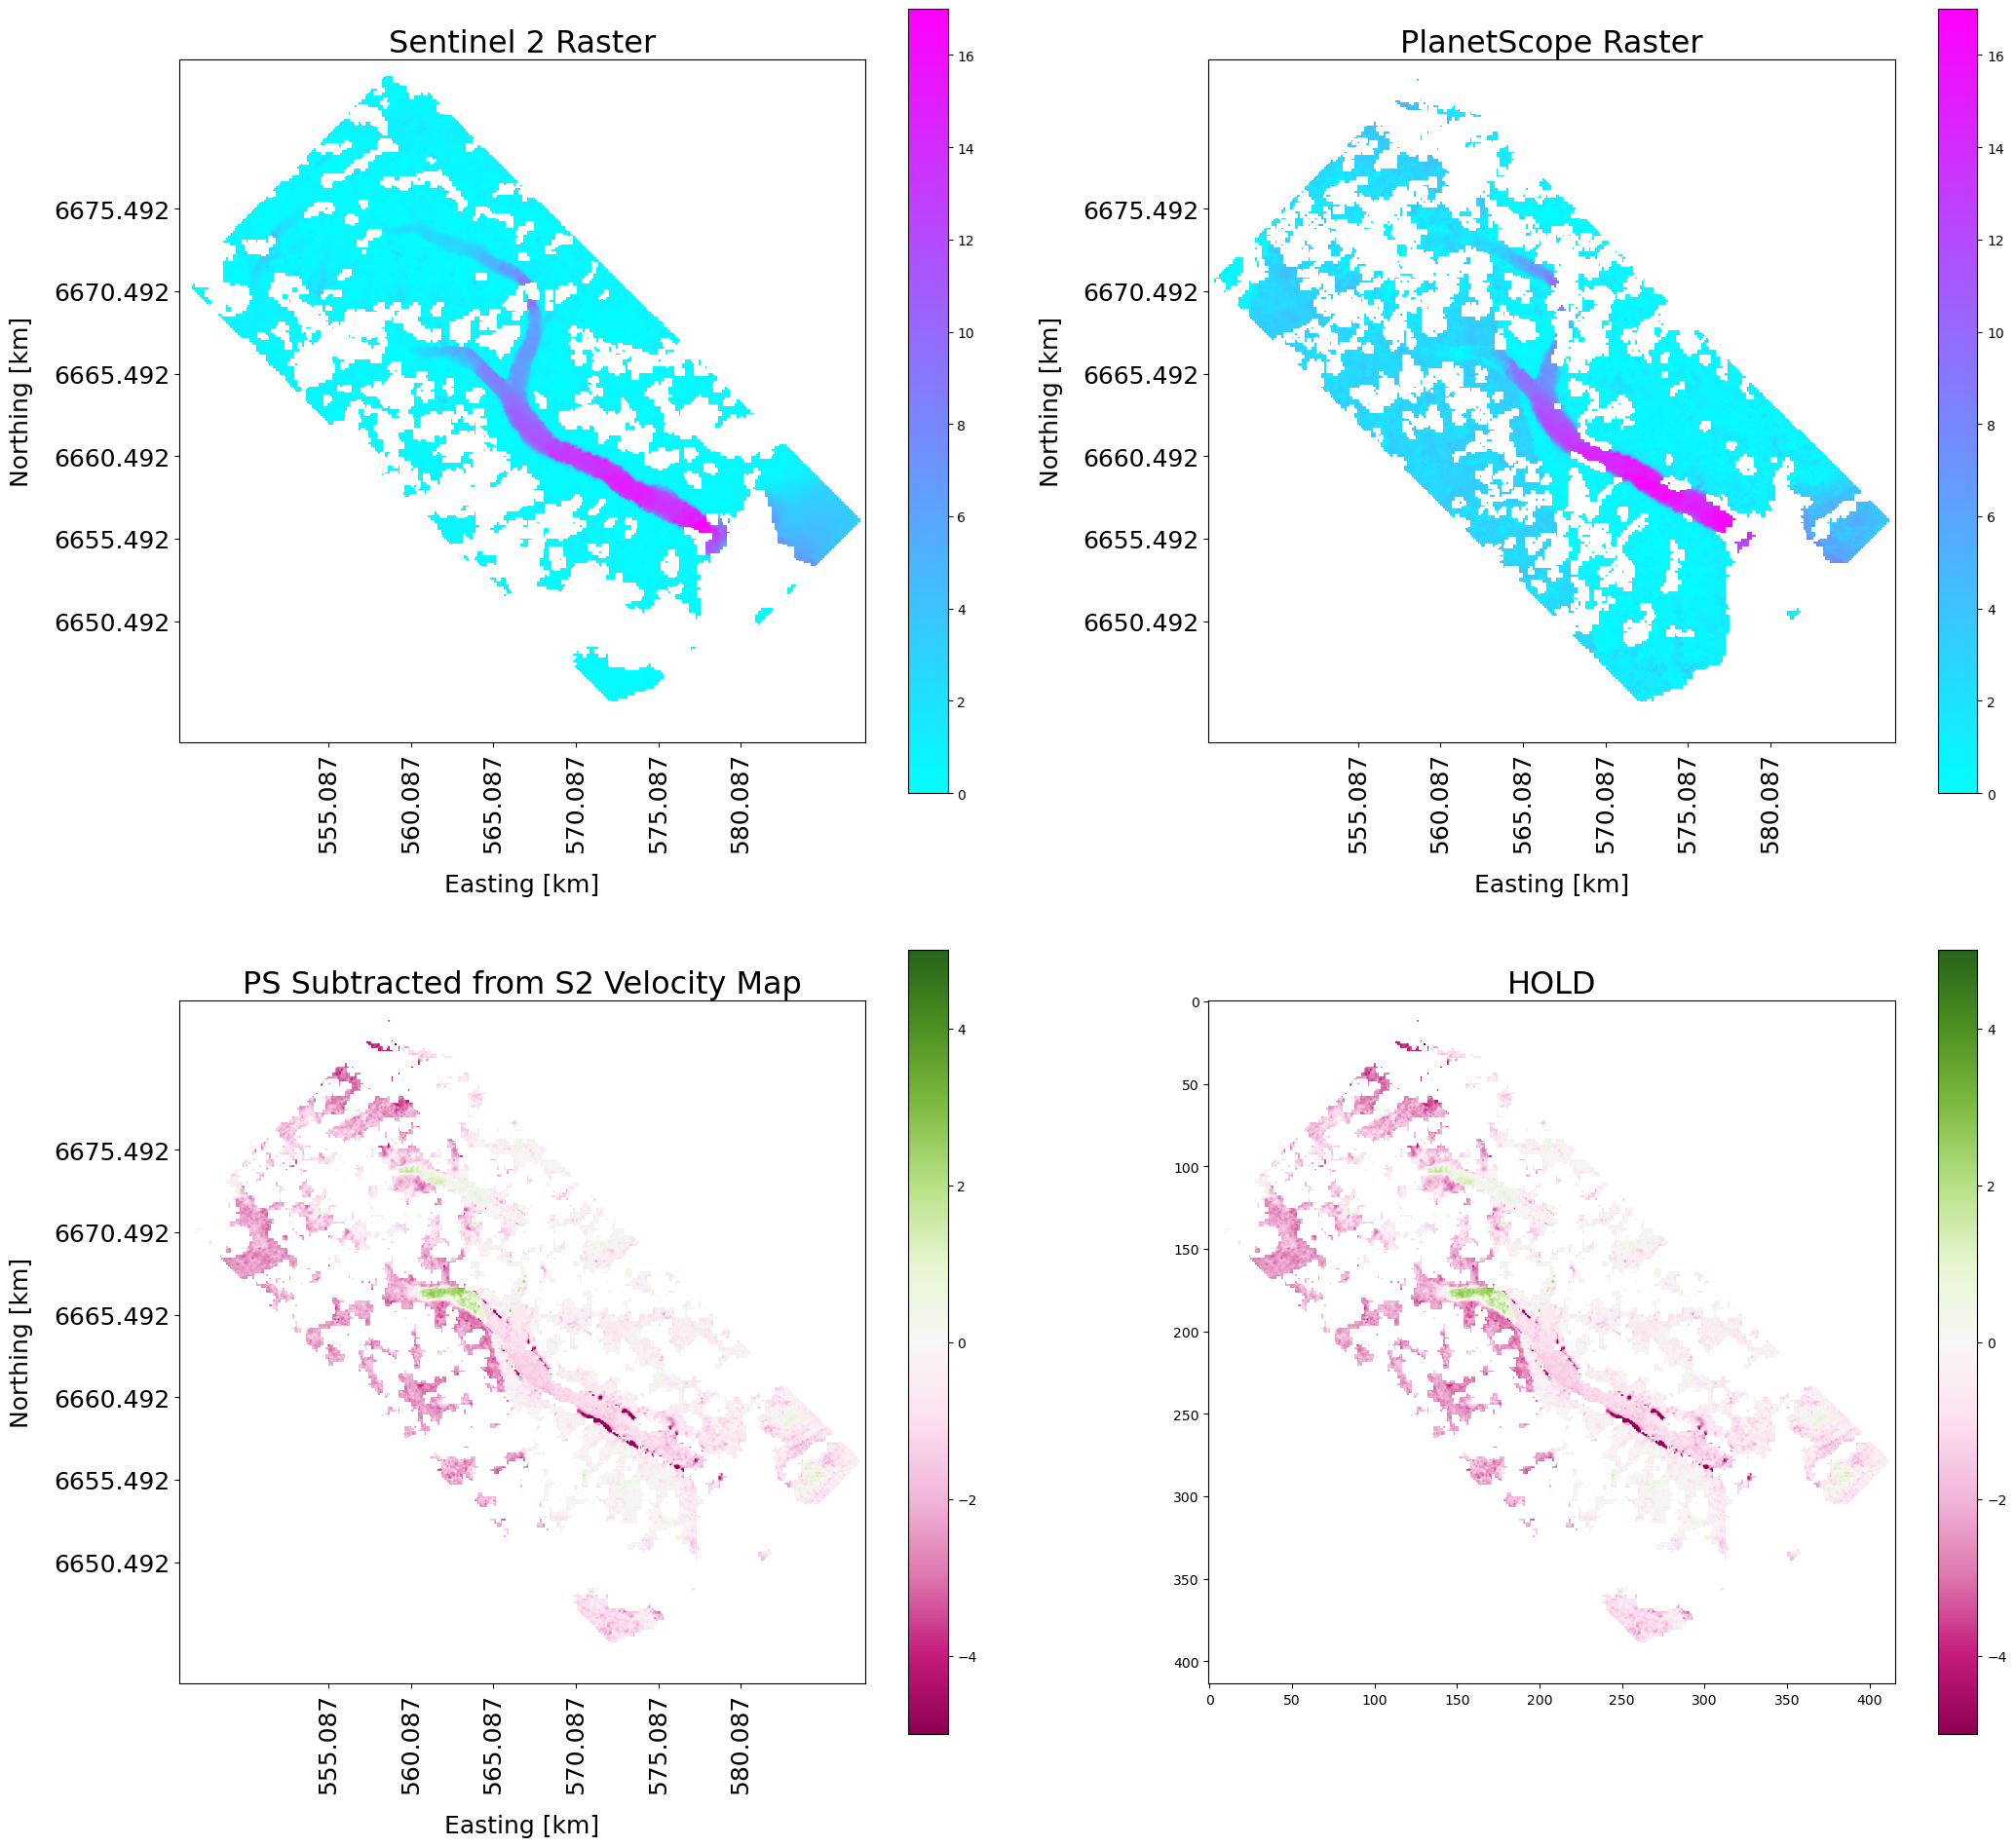

In [176]:
# Build Figures
fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2, figsize=(25, 23))

#sentinel 2
im1 = ax1.imshow(S2r/365, vmin=0, vmax=17, cmap='cool'); ax1.set_title('Sentinel 2 Raster', fontsize=fs+5); fig.colorbar(im1,ax=ax1)
# ticks and labels:
plt.sca(ax1)
plt.xticks(np.arange(x1,x2,tickspacing), labels = xS2_utms, rotation=90)
plt.yticks(np.arange(y1,y2,tickspacing), labels = yS2_utms)
plt.xlabel('Easting [km]',fontsize=fs, labelpad = 15); plt.ylabel('Northing [km]',fontsize=fs, labelpad = 15)
plt.tick_params(axis='both',labelsize=fs)

#planetscope
im2 = ax2.imshow(PSr/365, vmin=0, vmax=17, cmap='cool'); ax2.set_title('PlanetScope Raster', fontsize=fs+5); fig.colorbar(im2, ax=ax2)
# ticks and labels:
plt.sca(ax2)
plt.xticks(np.arange(x1,x2,tickspacing), labels = xPS_utms, rotation=90)
plt.yticks(np.arange(y1,y2,tickspacing), labels = yPS_utms)
plt.xlabel('Easting [km]',fontsize=fs, labelpad = 15); plt.ylabel('Northing [km]',fontsize=fs, labelpad = 15)
plt.tick_params(axis='both',labelsize=fs)

#difference raster
im3 = ax3.imshow(difference_raster/365,vmin=-5, vmax=5, cmap='PiYG'); ax3.set_title('PS Subtracted from S2 Velocity Map', fontsize=fs+5); fig.colorbar(im3,ax=ax3)
# ticks and labels:
plt.sca(ax3)
plt.xticks(np.arange(x1,x2,tickspacing), labels = xS2_utms, rotation=90)
plt.yticks(np.arange(y1,y2,tickspacing), labels = yS2_utms)
plt.xlabel('Easting [km]',fontsize=fs, labelpad = 15); plt.ylabel('Northing [km]',fontsize=fs, labelpad = 15)
plt.tick_params(axis='both',labelsize=fs)

# Hold Space
im4 = ax4.imshow(difference_raster/365,vmin=-5, vmax=5, cmap='PiYG'); ax4.set_title('HOLD', fontsize=fs+5); fig.colorbar(im4,ax=ax4)
plt.show()                
                            

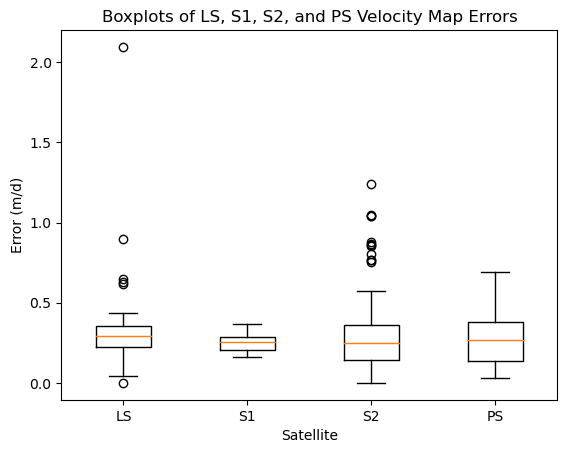

In [174]:
# Generate BoxPlot

data1 = pd.read_csv('/Users/maddiegendreau/Documents/CSVs/LS_Data.csv')['err_v']
data2 = pd.read_csv('/Users/maddiegendreau/Documents/CSVs/S1_Data.csv')['err_v']
data3 = pd.read_csv('/Users/maddiegendreau/Documents/CSVs/S2_Data.csv')['err_v']
data4 = pd.read_csv('/Users/maddiegendreau/Desktop/PS_Data.csv')['err_v']

data = [data1, data2, data3, data4]

positions = [1, 2, 3, 4]
labels = ['LS', 'S1', 'S2', 'PS']
plt.boxplot(data, positions=positions, labels=labels)

plt.xlabel('Satellite')
plt.ylabel('Error (m/d)')
plt.title('Boxplots of LS, S1, S2, and PS Velocity Map Errors')
plt.show()

In [178]:
#Import Velocity Rastors
LS_raster_path = '/Volumes/SGlacier/SK_vmaps_2020_2021/velocity_20201010_20201120_100m_LS.tif'
PS_raster_path = '/Volumes/SGlacier/autorift_OUTPUT_PSsurge/velocity_20201013_20201022_100m_PS.tif'

#specify plot params
fs = 18
tickspacing = 50
y1 = 90; y2 = 360
x1 = 90; x2 = 360

#sentinel2
reader = rio.open(LS_raster_path);
LSr = reader.read(3);
imgres = reader.transform[0]
xdLS, ydLS = LSr.shape
xLS_utms = np.arange(reader.bounds[0]+x1*imgres,reader.bounds[0]+x2*imgres,tickspacing*imgres).astype(int)/1000
yLS_utms = np.flip(np.arange(reader.bounds[1]+y1*imgres,reader.bounds[1]+y2*imgres,tickspacing*imgres).astype(int)/1000)

#planetscope
reader = rio.open(PS_raster_path); PSr = reader.read(3)
PSr = reader.read(3);
imgres = reader.transform[0]
xdPS, ydPS = PSr.shape
xPS_utms = np.arange(reader.bounds[0]+x1*imgres,reader.bounds[0]+x2*imgres,tickspacing*imgres).astype(int)/1000
yPS_utms = np.flip(np.arange(reader.bounds[1]+y1*imgres,reader.bounds[1]+y2*imgres,tickspacing*imgres).astype(int)/1000)

LSr_data = LSr.copy() # make a copy of the data
PSr_data = PSr.copy() # make a copy of the data
    
# Subtract The Rasters
difference_raster = LSr_data - PSr_data

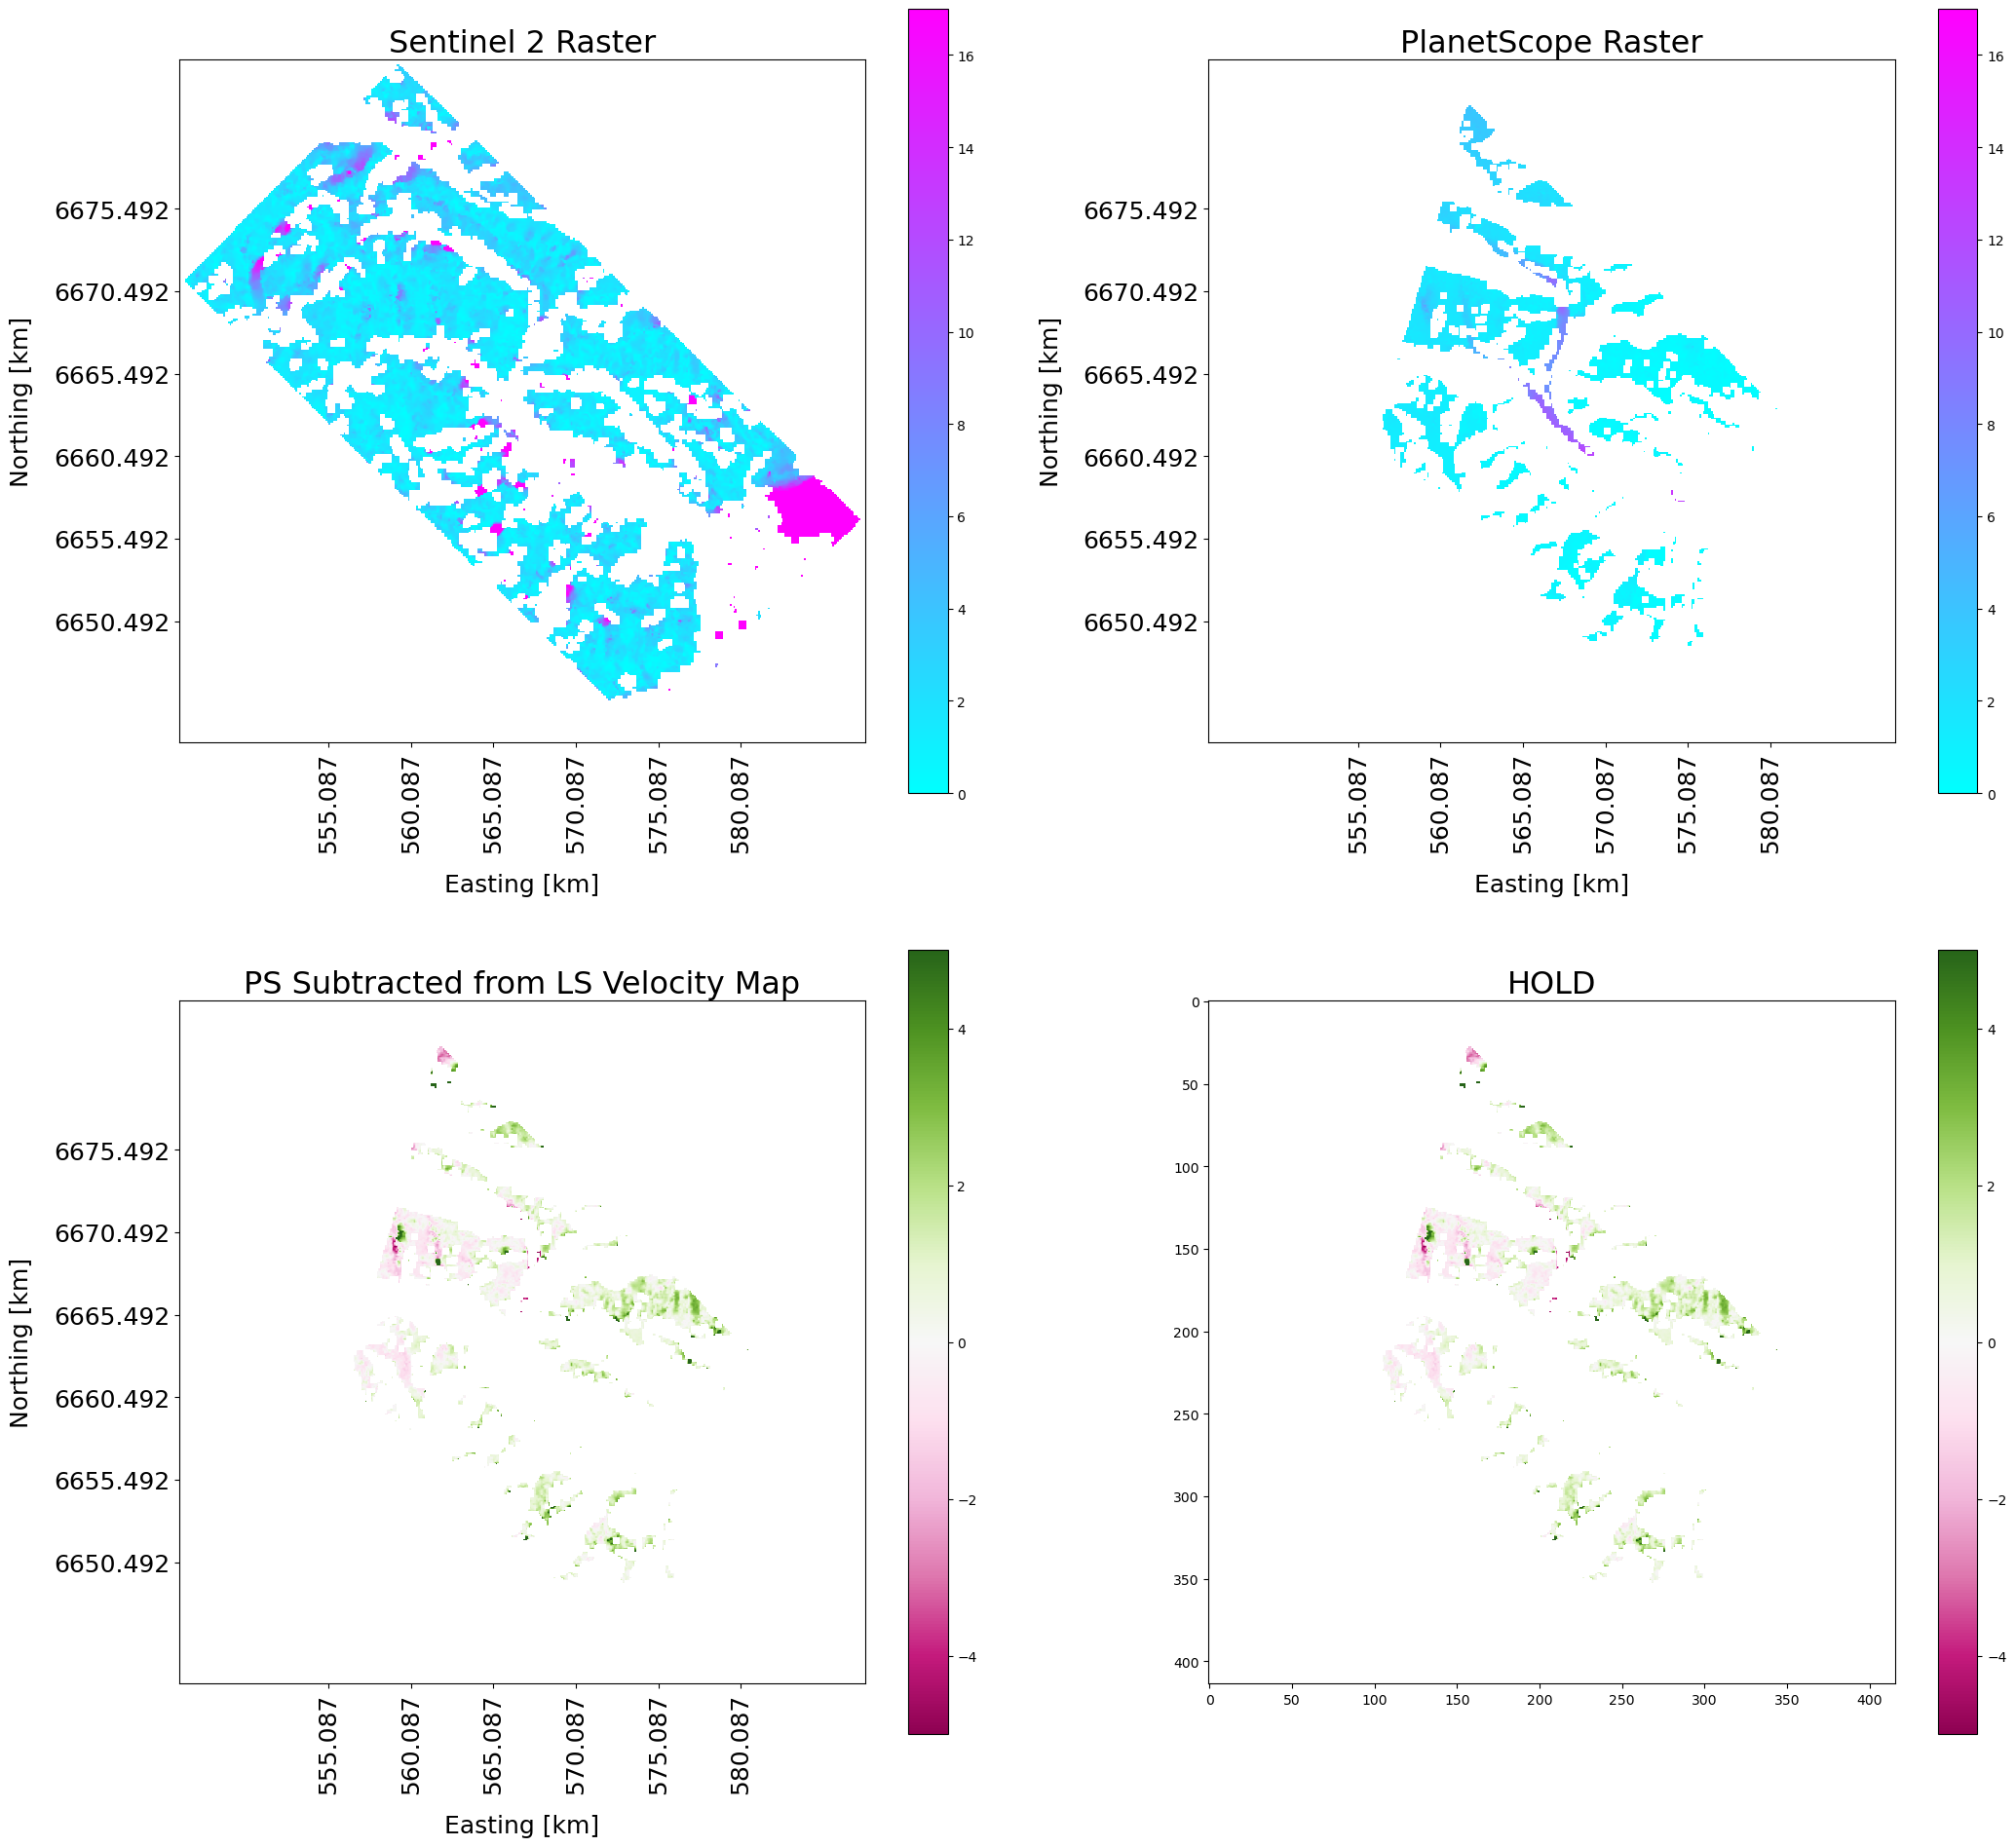

In [179]:
# Build Figures
fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2, figsize=(25, 23))

#sentinel 2
im1 = ax1.imshow(LSr/365, vmin=0, vmax=17, cmap='cool'); ax1.set_title('Sentinel 2 Raster', fontsize=fs+5); fig.colorbar(im1,ax=ax1)
# ticks and labels:
plt.sca(ax1)
plt.xticks(np.arange(x1,x2,tickspacing), labels = xLS_utms, rotation=90)
plt.yticks(np.arange(y1,y2,tickspacing), labels = yLS_utms)
plt.xlabel('Easting [km]',fontsize=fs, labelpad = 15); plt.ylabel('Northing [km]',fontsize=fs, labelpad = 15)
plt.tick_params(axis='both',labelsize=fs)

#planetscope
im2 = ax2.imshow(PSr/365, vmin=0, vmax=17, cmap='cool'); ax2.set_title('PlanetScope Raster', fontsize=fs+5); fig.colorbar(im2, ax=ax2)
# ticks and labels:
plt.sca(ax2)
plt.xticks(np.arange(x1,x2,tickspacing), labels = xPS_utms, rotation=90)
plt.yticks(np.arange(y1,y2,tickspacing), labels = yPS_utms)
plt.xlabel('Easting [km]',fontsize=fs, labelpad = 15); plt.ylabel('Northing [km]',fontsize=fs, labelpad = 15)
plt.tick_params(axis='both',labelsize=fs)

#difference raster
im3 = ax3.imshow(difference_raster/365,vmin=-5, vmax=5, cmap='PiYG'); ax3.set_title('PS Subtracted from LS Velocity Map', fontsize=fs+5); fig.colorbar(im3,ax=ax3)
# ticks and labels:
plt.sca(ax3)
plt.xticks(np.arange(x1,x2,tickspacing), labels = xLS_utms, rotation=90)
plt.yticks(np.arange(y1,y2,tickspacing), labels = yLS_utms)
plt.xlabel('Easting [km]',fontsize=fs, labelpad = 15); plt.ylabel('Northing [km]',fontsize=fs, labelpad = 15)
plt.tick_params(axis='both',labelsize=fs)

# Hold Space
im4 = ax4.imshow(difference_raster/365,vmin=-5, vmax=5, cmap='PiYG'); ax4.set_title('HOLD', fontsize=fs+5); fig.colorbar(im4,ax=ax4)
plt.show()                
                            